# Setup | 设置

Latest Update: 05/19/2025

## Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
# Set font to support Chinese characters
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font for Chinese
plt.rcParams['axes.unicode_minus'] = False    # Fix minus sign display
sns.set_palette("husl")

# import math
# import json
import os
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## Global Var

In [2]:
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root_path not in sys.path:
    sys.path.append(project_root_path)

In [3]:
input_superior_path = 'output/'
ouput_superior_path = 'output/'

## Built-in Functions

In [4]:
def get_your_df(input_superior_path, file_name):
    file_path = os.path.join(project_root_path, input_superior_path, (str(file_name) + '.xlsx'))
    df_data_analysis = pd.read_excel(file_path)

    return df_data_analysis

In [5]:
def output_your_df(df_data_analysis, output_superior_path, file_name):
    file_path = os.path.join(project_root_path, output_superior_path, (str(file_name) + '.xlsx'))
    df_data_analysis.to_excel(file_path, index=False, engine='openpyxl')

    print(f"File saved to: {file_path}")

In [6]:
def generate_statistical_summary(df):
    print("\n=== Statistical Summary ===")
    
    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("\nNumeric Columns Summary:")
    print(df[numeric_cols].describe())
    
    # Date columns summary
    date_cols = ['下线日期 (或当前日志时间)', '上线日期']
    print("\nDate Range Summary:")
    for col in date_cols:
        print(f"\n{col}:")
        print(f"Min: {df[col].min()}")
        print(f"Max: {df[col].max()}")
    
    return df[numeric_cols].describe()

In [7]:
def analyze_distributions(df):
    print("\n=== Distribution Analysis ===")
    
    # Select numeric columns for distribution analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Create distribution plots
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, ax=axes[idx], kde=True)
        axes[idx].set_title(f'{col}的分布')
    
    # Remove empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

In [11]:
# Outlier detection using IQR method for key variables
def detect_outliers(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_indices[col] = outliers.index.tolist()
        print(f"{col}: {len(outliers)} outliers")
    return outlier_indices

In [24]:
def analyze_outliers(df, key_vars):
    print("\n=== Outlier Analysis ===")
    
    # Calculate number of rows and columns for subplot grid
    n_cols = 4
    n_rows = (len(key_vars) + n_cols - 1) // n_cols  # Ceiling division

    plt.figure(figsize=(18, 4.5*n_rows))  # Adjust figure height based on number of rows
    for i, col in enumerate(key_vars, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(y=df[col], color='salmon')
        plt.title(col)
    plt.tight_layout()
    plt.show()

# Work Space | 工作区

## Original Processed Dataset | 初始受理数据集

In [ ]:
df_general_log_stat_haida = get_your_df(
    input_superior_path=input_superior_path, 
    file_name='基于日记250507-海大设备数据分析-250515'
)
# df_general_log_stat_haida.head(5)

## Futures Scaling | 特征缩放 [冻结]

\>> 通过换算频率或者换算月均值，对易影响数据分析的一系列频次指标进行缩放处理

Latest Update: 05/19/2025

### Scaling by Monthly Average

In [12]:
# Get frequency-related columns that start with 'times_of_' (end with '次数')
freq_cols = [col for col in df_general_log_stat_haida.columns if col.endswith('次数')]

# Divide frequency-related columns by months_len_exclude_breaks for scaling
df_general_log_stat_scaled_month_haida = df_general_log_stat_haida.copy()
for col in freq_cols:
    df_general_log_stat_scaled_month_haida[col] = round(
        df_general_log_stat_scaled_month_haida[col] / df_general_log_stat_scaled_month_haida['实际使用月数 (不含中途离线)'],
        2
    )

# df_general_log_stat_scaled_month_haida.head(5)

In [17]:
file_name = '基于日记250507-海大设备数据分析-月均化缩放-250519'

output_your_df(df_general_log_stat_scaled_month_haida, ouput_superior_path, file_name)

File saved to: d:\project_code\project_donglee_intern\output/基于日记250507-海大设备数据分析-月均化缩放-250519.xlsx


### Scaling by Probability

In [13]:
# Get frequency-related columns
freq_cols_operation = [
    '设备待机次数',
    '开启灌溉次数',
    '关闭灌溉次数',
    '设备上线次数',
    '设备下线次数'
]

freq_cols_signal_strength = [
    '强信号次数',
    '中等强度次数',
    '弱强度次数',
    '无信号次数',
]

freq_cols_signal_switch = [
    '强/中信号切换次数',
    '强/弱信号切换次数',
    '强/无信号切换次数',
    '中/弱信号切换次数',
    '中/无信号切换次数',
    '弱/无信号切换次数'
]

# Divide frequency-related columns by their corresponding sample size for scaling
df_general_log_stat_scaled_prob_haida = df_general_log_stat_haida.copy()

# Calculate sample size
total_operations = (
    df_general_log_stat_scaled_prob_haida['设备待机次数'] +
    df_general_log_stat_scaled_prob_haida['开启灌溉次数'] +
    df_general_log_stat_scaled_prob_haida['关闭灌溉次数'] +
    df_general_log_stat_scaled_prob_haida['设备上线次数'] +
    df_general_log_stat_scaled_prob_haida['设备下线次数']
)
total_signals = (
    df_general_log_stat_scaled_prob_haida['强信号次数'] +
    df_general_log_stat_scaled_prob_haida['中等强度次数'] +
    df_general_log_stat_scaled_prob_haida['弱强度次数'] +
    df_general_log_stat_scaled_prob_haida['无信号次数']
)
total_switches = (
    df_general_log_stat_scaled_prob_haida['强/中信号切换次数'] +
    df_general_log_stat_scaled_prob_haida['强/弱信号切换次数'] +
    df_general_log_stat_scaled_prob_haida['强/无信号切换次数'] +
    df_general_log_stat_scaled_prob_haida['中/弱信号切换次数'] +
    df_general_log_stat_scaled_prob_haida['中/无信号切换次数'] +
    df_general_log_stat_scaled_prob_haida['弱/无信号切换次数']
)

# Implement scaling
for col in freq_cols_operation:
    if col == '开启灌溉次数' or col == '关闭灌溉次数':
        df_general_log_stat_scaled_prob_haida[col] = round(
            df_general_log_stat_scaled_prob_haida[col] * 10 / total_operations,
            2
        )
    else:
        df_general_log_stat_scaled_prob_haida[col] = round(
            df_general_log_stat_scaled_prob_haida[col] / total_operations,
            2
        )

for col in freq_cols_signal_strength:
    df_general_log_stat_scaled_prob_haida[col] = round(
        df_general_log_stat_scaled_prob_haida[col] / total_signals,
        2
    )
for col in freq_cols_signal_switch:
    df_general_log_stat_scaled_prob_haida[col] = round(
        df_general_log_stat_scaled_prob_haida[col] / total_switches,
        2
    )

# df_general_log_stat_scaled_prob_haida.head(5)

In [18]:
file_name = '基于日记250507-海大设备数据分析-概率化缩放-250519'

output_your_df(df_general_log_stat_scaled_prob_haida, ouput_superior_path, file_name)

File saved to: d:\project_code\project_donglee_intern\output/基于日记250507-海大设备数据分析-概率化缩放-250519.xlsx


## Elementary Data Analysis | 基础数据分析

### Data Reloading

\>> 对上一步得到的统计表进行基本但主流的 Python 数据分析

In [9]:
df_general_log_stat_scaled_month_haida = get_your_df(
    input_superior_path=input_superior_path, 
    file_name='基于日记250507-海大设备数据分析-月均化缩放-250519'
)
# df_general_log_stat_scaled_month_haida.head(5)

In [10]:
df_general_log_stat_scaled_prob_haida = get_your_df(
    input_superior_path=input_superior_path, 
    file_name='基于日记250507-海大设备数据分析-概率化缩放-250519'
)
# df_general_log_stat_scaled_prob_haida.head(5)

Note Forward: 是否要根据非零值的比例舍去部分特征？

In [ ]:
# # Calculate zero-value proportion for each frequency column
# zero_proportions = {}
# for col in freq_cols:
#     zero_count = (df_general_log_stat_scaled_month_haida[col] < 0.1).sum()
#     total_count = len(df_general_log_stat_scaled_month_haida)
#     zero_proportions[col] = zero_count / total_count

# # Set threshold for dropping columns (e.g., 80% zeros)
# threshold = 0.8
# cols_to_drop = [col for col, prop in zero_proportions.items() if prop >= threshold]

# # Print results
# print("Zero-value proportions for frequency columns:")
# for col, prop in zero_proportions.items():
#     print(f"{col}: {prop:.2%} zeros")
# print(f"\nColumns to drop (≥{threshold:.0%} zeros): {cols_to_drop}")

# # Drop columns with too many zeros
# df_general_log_stat_scaled_month_haida = df_general_log_stat_scaled_month_haida.drop(columns=cols_to_drop)
# freq_cols = [col for col in freq_cols if col not in cols_to_drop]

# # Display updated dataframe
# df_general_log_stat_scaled_month_haida.head()

### Missing Value and Duplication

\>> 检测缺失值与重复值 (实际上对本数据源不适用)

Latest Update: 05/15/2025

In [ ]:
# Check data quality: missing value (null)
missing_info = pd.DataFrame({'missing_values': df_general_log_stat_haida.isnull().sum()})
display(missing_info[missing_info['missing_values'] > 0])

,missing_values


In [ ]:
# Check data quality: duplication (row)
df_general_log_stat_haida.duplicated().sum()

np.int64(0)

### Distribution and Outlier Detection

\>> 概览各个特征的分布，以了解不同特征的稳定性与随机性差异；对于异常值明显的分布，重点关注后续该特征与兴趣变量 (设备的使用生命周期)之间的相关性

Latest Update: 05/19/2025

In [27]:
generate_statistical_summary(df_general_log_stat_haida)


=== Statistical Summary ===

Numeric Columns Summary:
             设备编号         日志长度  使用月数 (包含中途离线)      设备离线次数      最大离线天数  \
count  110.000000   110.000000     110.000000  110.000000  110.000000   
mean    30.709091  3602.500000       4.118182    1.327273   27.145455   
std     17.224553  1541.432366       1.717326    1.300029   46.330056   
min      1.000000   742.000000       1.000000    0.000000    0.000000   
25%     17.000000  2198.500000       3.000000    1.000000    2.000000   
50%     29.500000  3836.500000       4.000000    1.000000    2.000000   
75%     44.000000  4688.250000       6.000000    1.750000   33.500000   
max     64.000000  9439.000000       8.000000   10.000000  188.000000   

           总计离线天数  实际使用月数 (不含中途离线)       设备待机次数      开启灌溉次数      关闭灌溉次数  ...  \
count  110.000000       110.000000   110.000000  110.000000  110.000000  ...   
mean    29.463636         3.318182  2184.854545   49.618182   49.527273  ...   
std     49.819247         1.284572   769.385229

,设备编号,日志长度,使用月数 (包含中途离线),设备离线次数,最大离线天数,总计离线天数,实际使用月数 (不含中途离线),设备待机次数,开启灌溉次数,关闭灌溉次数,...,无信号次数,平均信号强度,最小信号强度,最大信号强度,强/中信号切换次数,强/弱信号切换次数,强/无信号切换次数,中/弱信号切换次数,中/无信号切换次数,弱/无信号切换次数
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,...,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,30.709091,3602.500000,4.118182,1.327273,27.145455,29.463636,3.318182,2184.854545,49.618182,49.527273,...,4.709091,20.037364,1.772727,29.463636,196.054545,1.436364,0.090909,27.427273,0.072727,0.545455
std,17.224553,1541.432366,1.717326,1.300029,46.330056,49.819247,1.284572,769.385229,36.445254,37.841463,...,5.489515,2.829982,4.112320,2.057331,158.480621,2.503309,0.418504,60.024683,0.350860,2.252975
min,1.000000,742.000000,1.000000,0.000000,0.000000,0.000000,1.000000,692.000000,0.000000,0.000000,...,0.000000,11.580000,0.000000,22.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,2198.500000,3.000000,1.000000,2.000000,2.000000,2.000000,1631.500000,12.000000,11.000000,...,1.000000,18.402500,0.000000,28.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.500000,3836.500000,4.000000,1.000000,2.000000,2.000000,3.000000,1986.500000,52.000000,52.500000,...,3.000000,20.260000,0.000000,31.000000,143.000000,1.000000,0.000000,7.000000,0.000000,0.000000
75%,44.000000,4688.250000,6.000000,1.750000,33.500000,35.000000,4.000000,2759.000000,70.500000,66.000000,...,7.000000,21.975000,0.000000,31.000000,287.750000,2.000000,0.000000,20.000000,0.000000,0.000000
max,64.000000,9439.000000,8.000000,10.000000,188.000000,193.000000,6.000000,3685.000000,169.000000,180.000000,...,25.000000,25.600000,18.000000,31.000000,915.000000,15.000000,3.000000,411.000000,3.000000,18.000000



=== Distribution Analysis ===


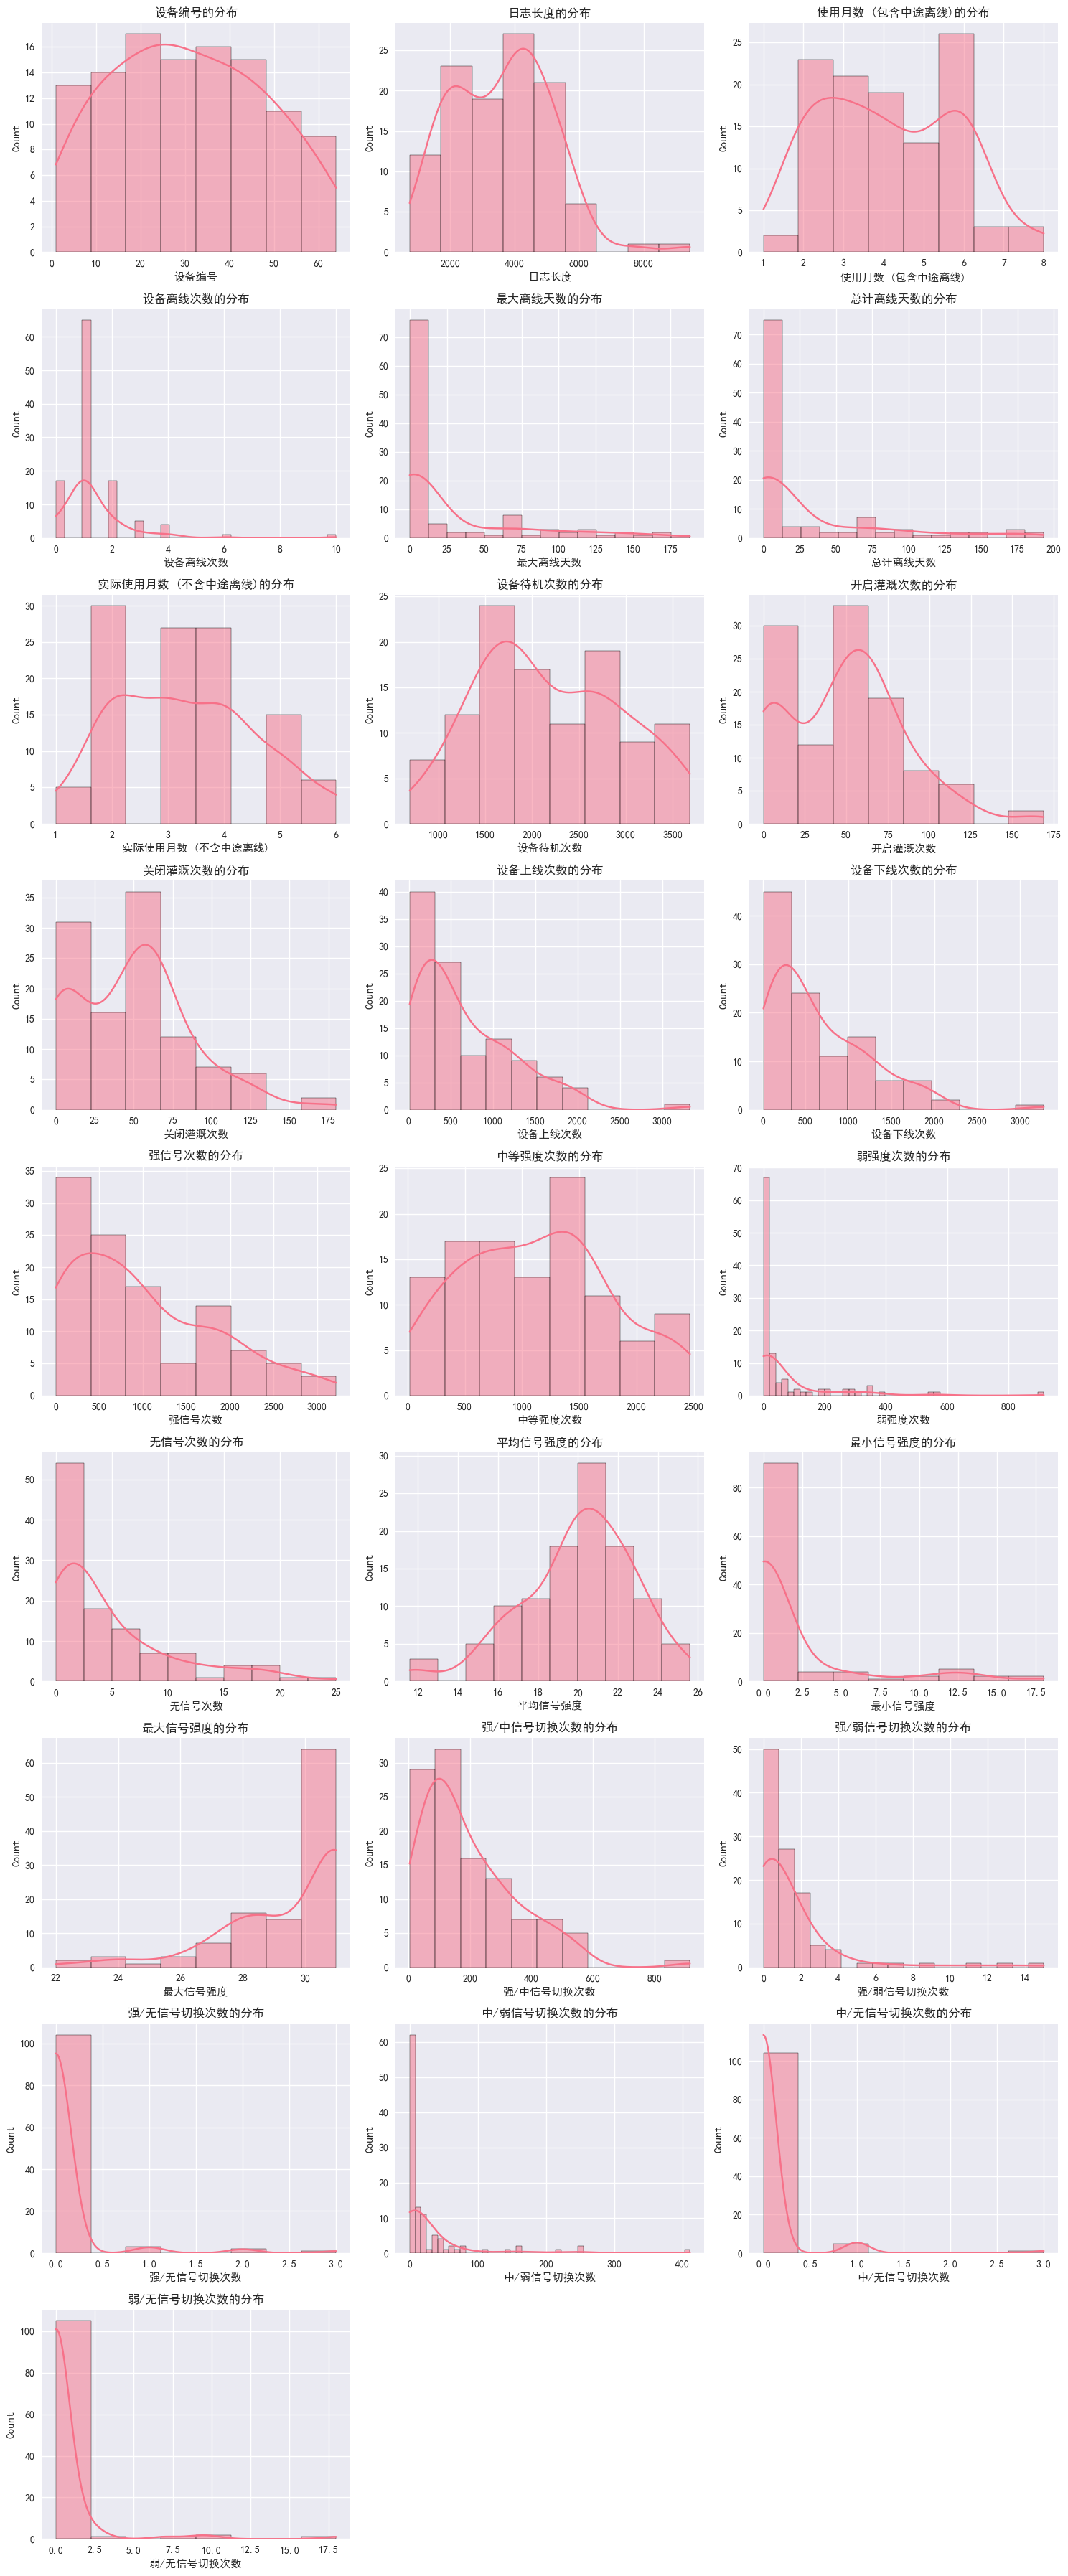

In [31]:
analyze_distributions(df_general_log_stat_haida)

In [19]:
key_vars = df_general_log_stat_haida.columns.tolist()
key_vars = key_vars[6:]
key_vars.remove('连续性')

In [20]:
# Key variables to check for outliers
key_vars

['使用月数 (包含中途离线)',
 '设备离线次数',
 '最大离线天数',
 '总计离线天数',
 '实际使用月数 (不含中途离线)',
 '设备待机次数',
 '开启灌溉次数',
 '关闭灌溉次数',
 '设备上线次数',
 '设备下线次数',
 '强信号次数',
 '中等强度次数',
 '弱强度次数',
 '无信号次数',
 '平均信号强度',
 '最小信号强度',
 '最大信号强度',
 '强/中信号切换次数',
 '强/弱信号切换次数',
 '强/无信号切换次数',
 '中/弱信号切换次数',
 '中/无信号切换次数',
 '弱/无信号切换次数']

In [21]:
outlier_indices = detect_outliers(df_general_log_stat_haida, key_vars)

使用月数 (包含中途离线): 0 outliers
设备离线次数: 11 outliers
最大离线天数: 16 outliers
总计离线天数: 16 outliers
实际使用月数 (不含中途离线): 0 outliers
设备待机次数: 0 outliers
开启灌溉次数: 1 outliers
关闭灌溉次数: 2 outliers
设备上线次数: 1 outliers
设备下线次数: 1 outliers
强信号次数: 0 outliers
中等强度次数: 0 outliers
弱强度次数: 18 outliers
无信号次数: 7 outliers
平均信号强度: 3 outliers
最小信号强度: 27 outliers
最大信号强度: 2 outliers
强/中信号切换次数: 1 outliers
强/弱信号切换次数: 6 outliers
强/无信号切换次数: 6 outliers
中/弱信号切换次数: 14 outliers
中/无信号切换次数: 6 outliers
弱/无信号切换次数: 13 outliers



=== Outlier Analysis ===


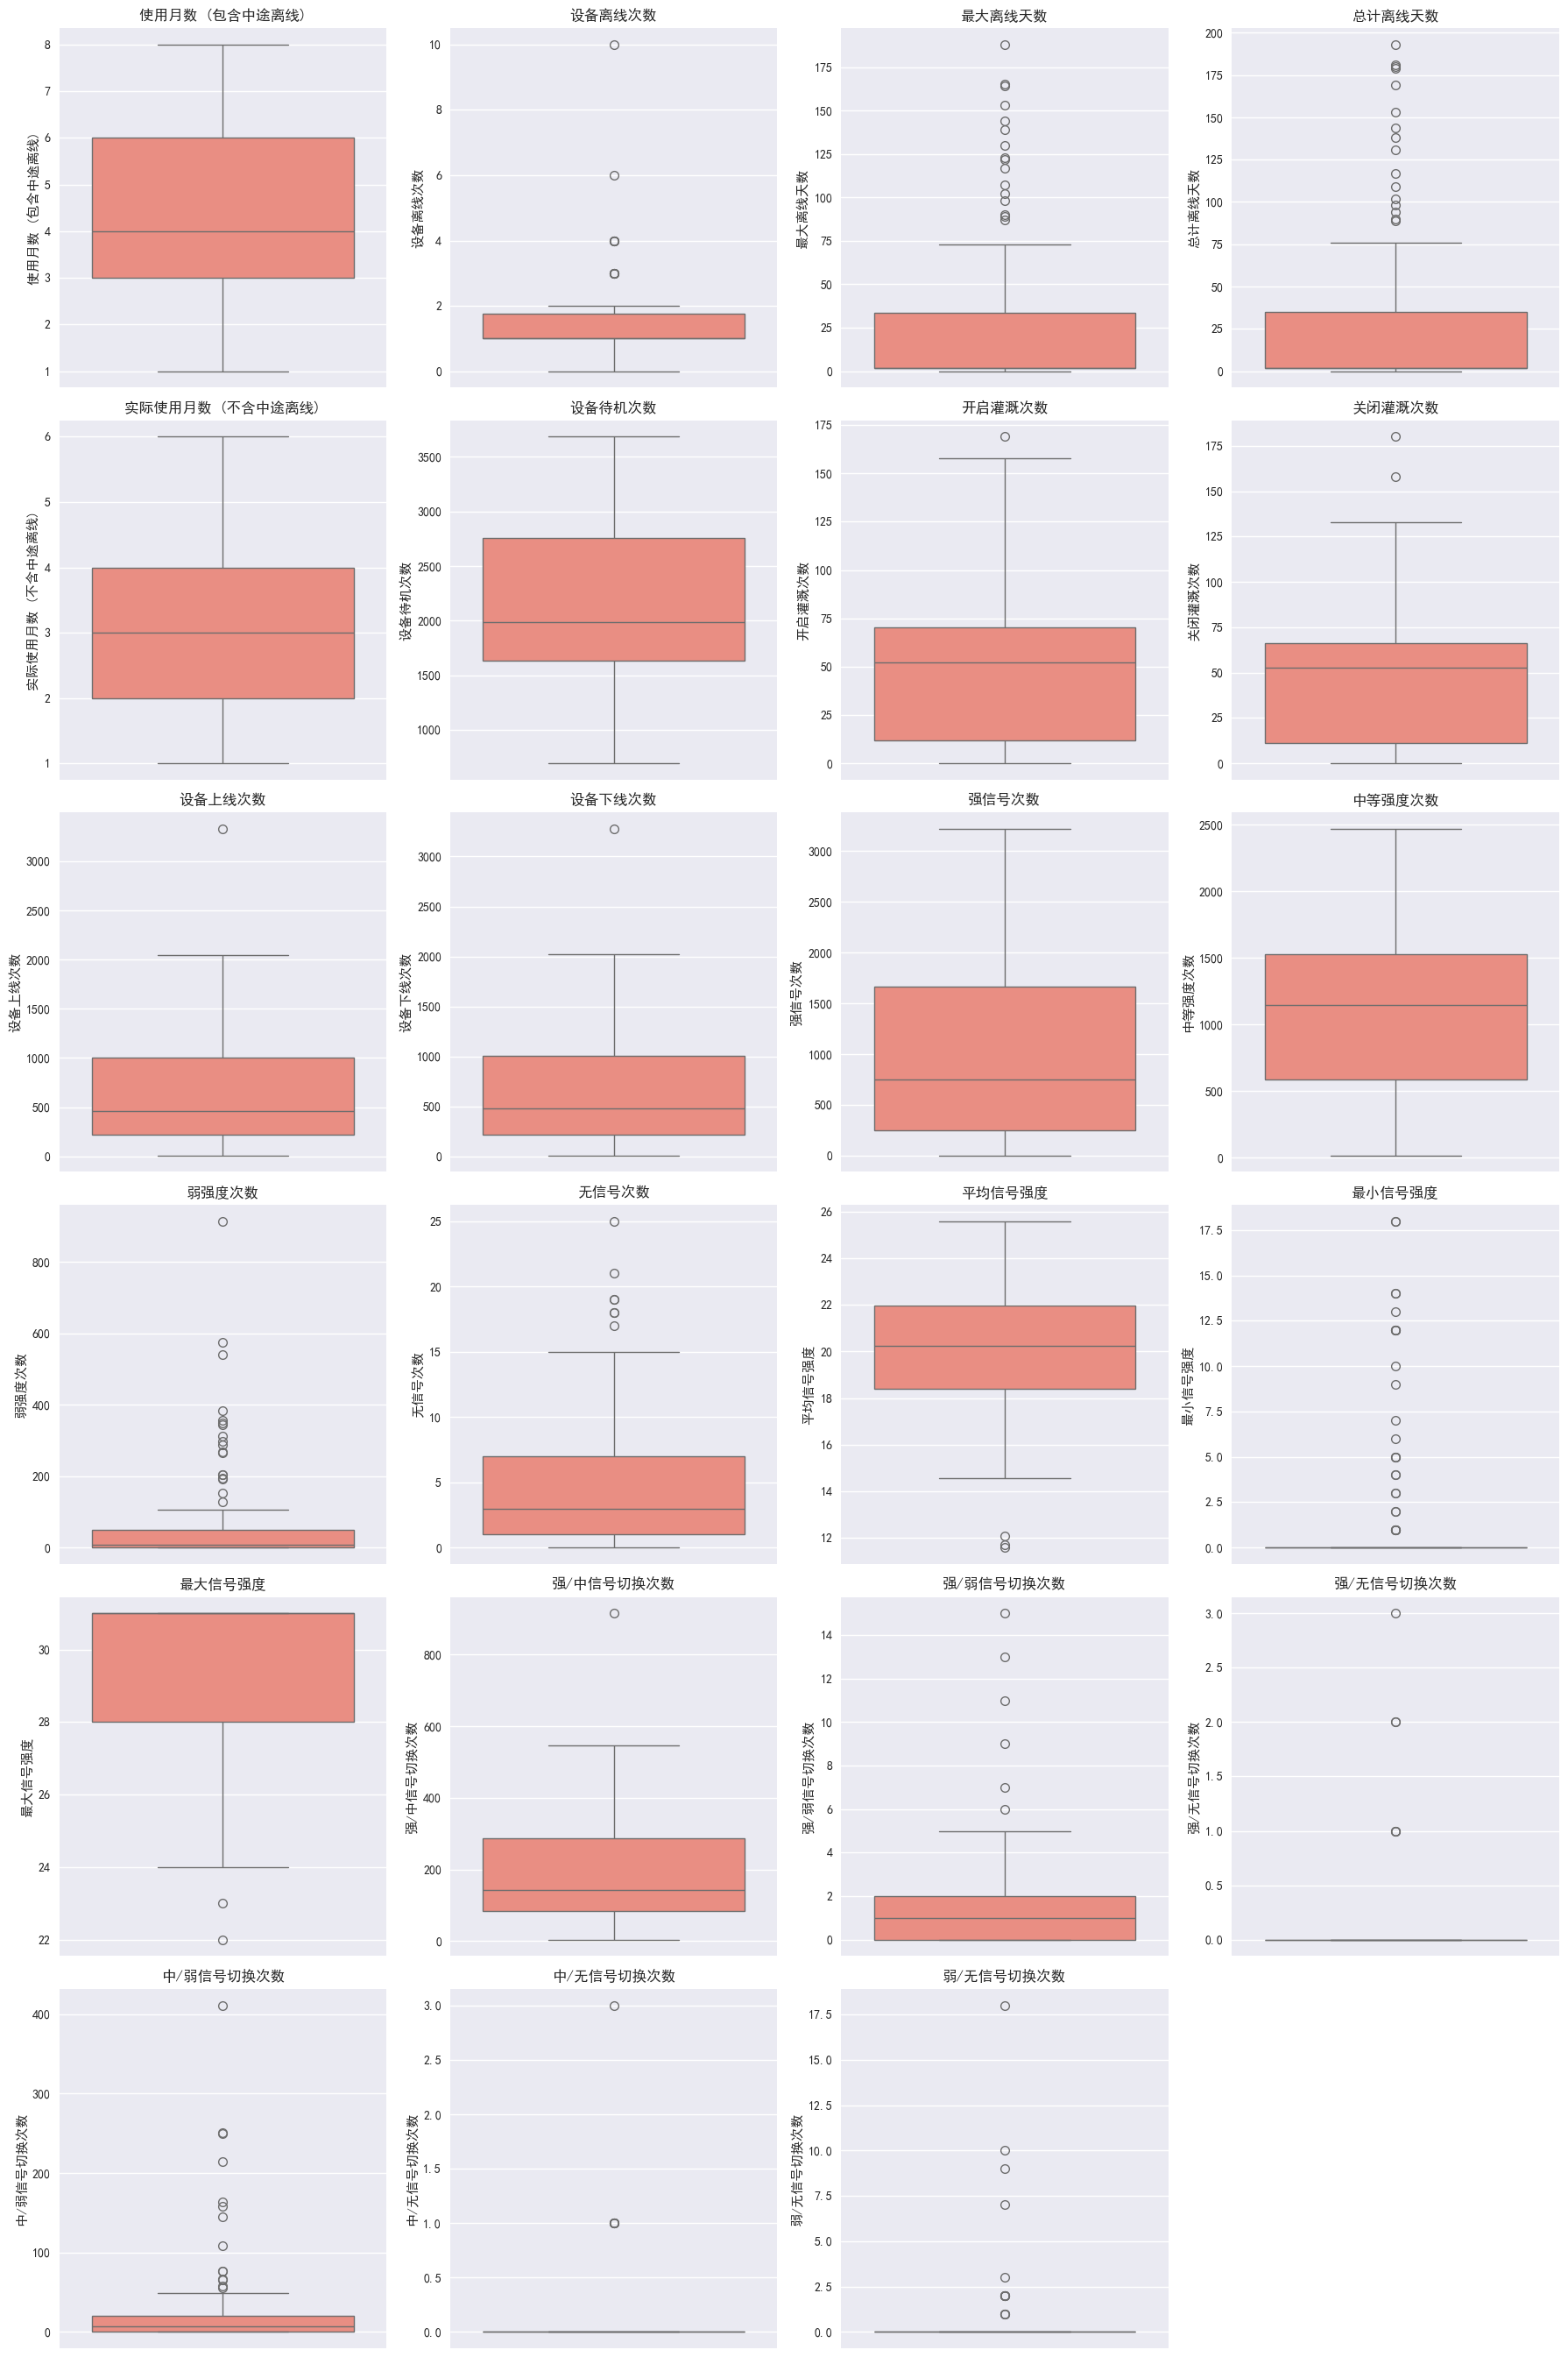

In [25]:
analyze_outliers(df_general_log_stat_haida, key_vars)

### Correlation Analysis

首要目的：寻找影响设备使用时间的潜在相关因素

Latest Update: 05/19/2025

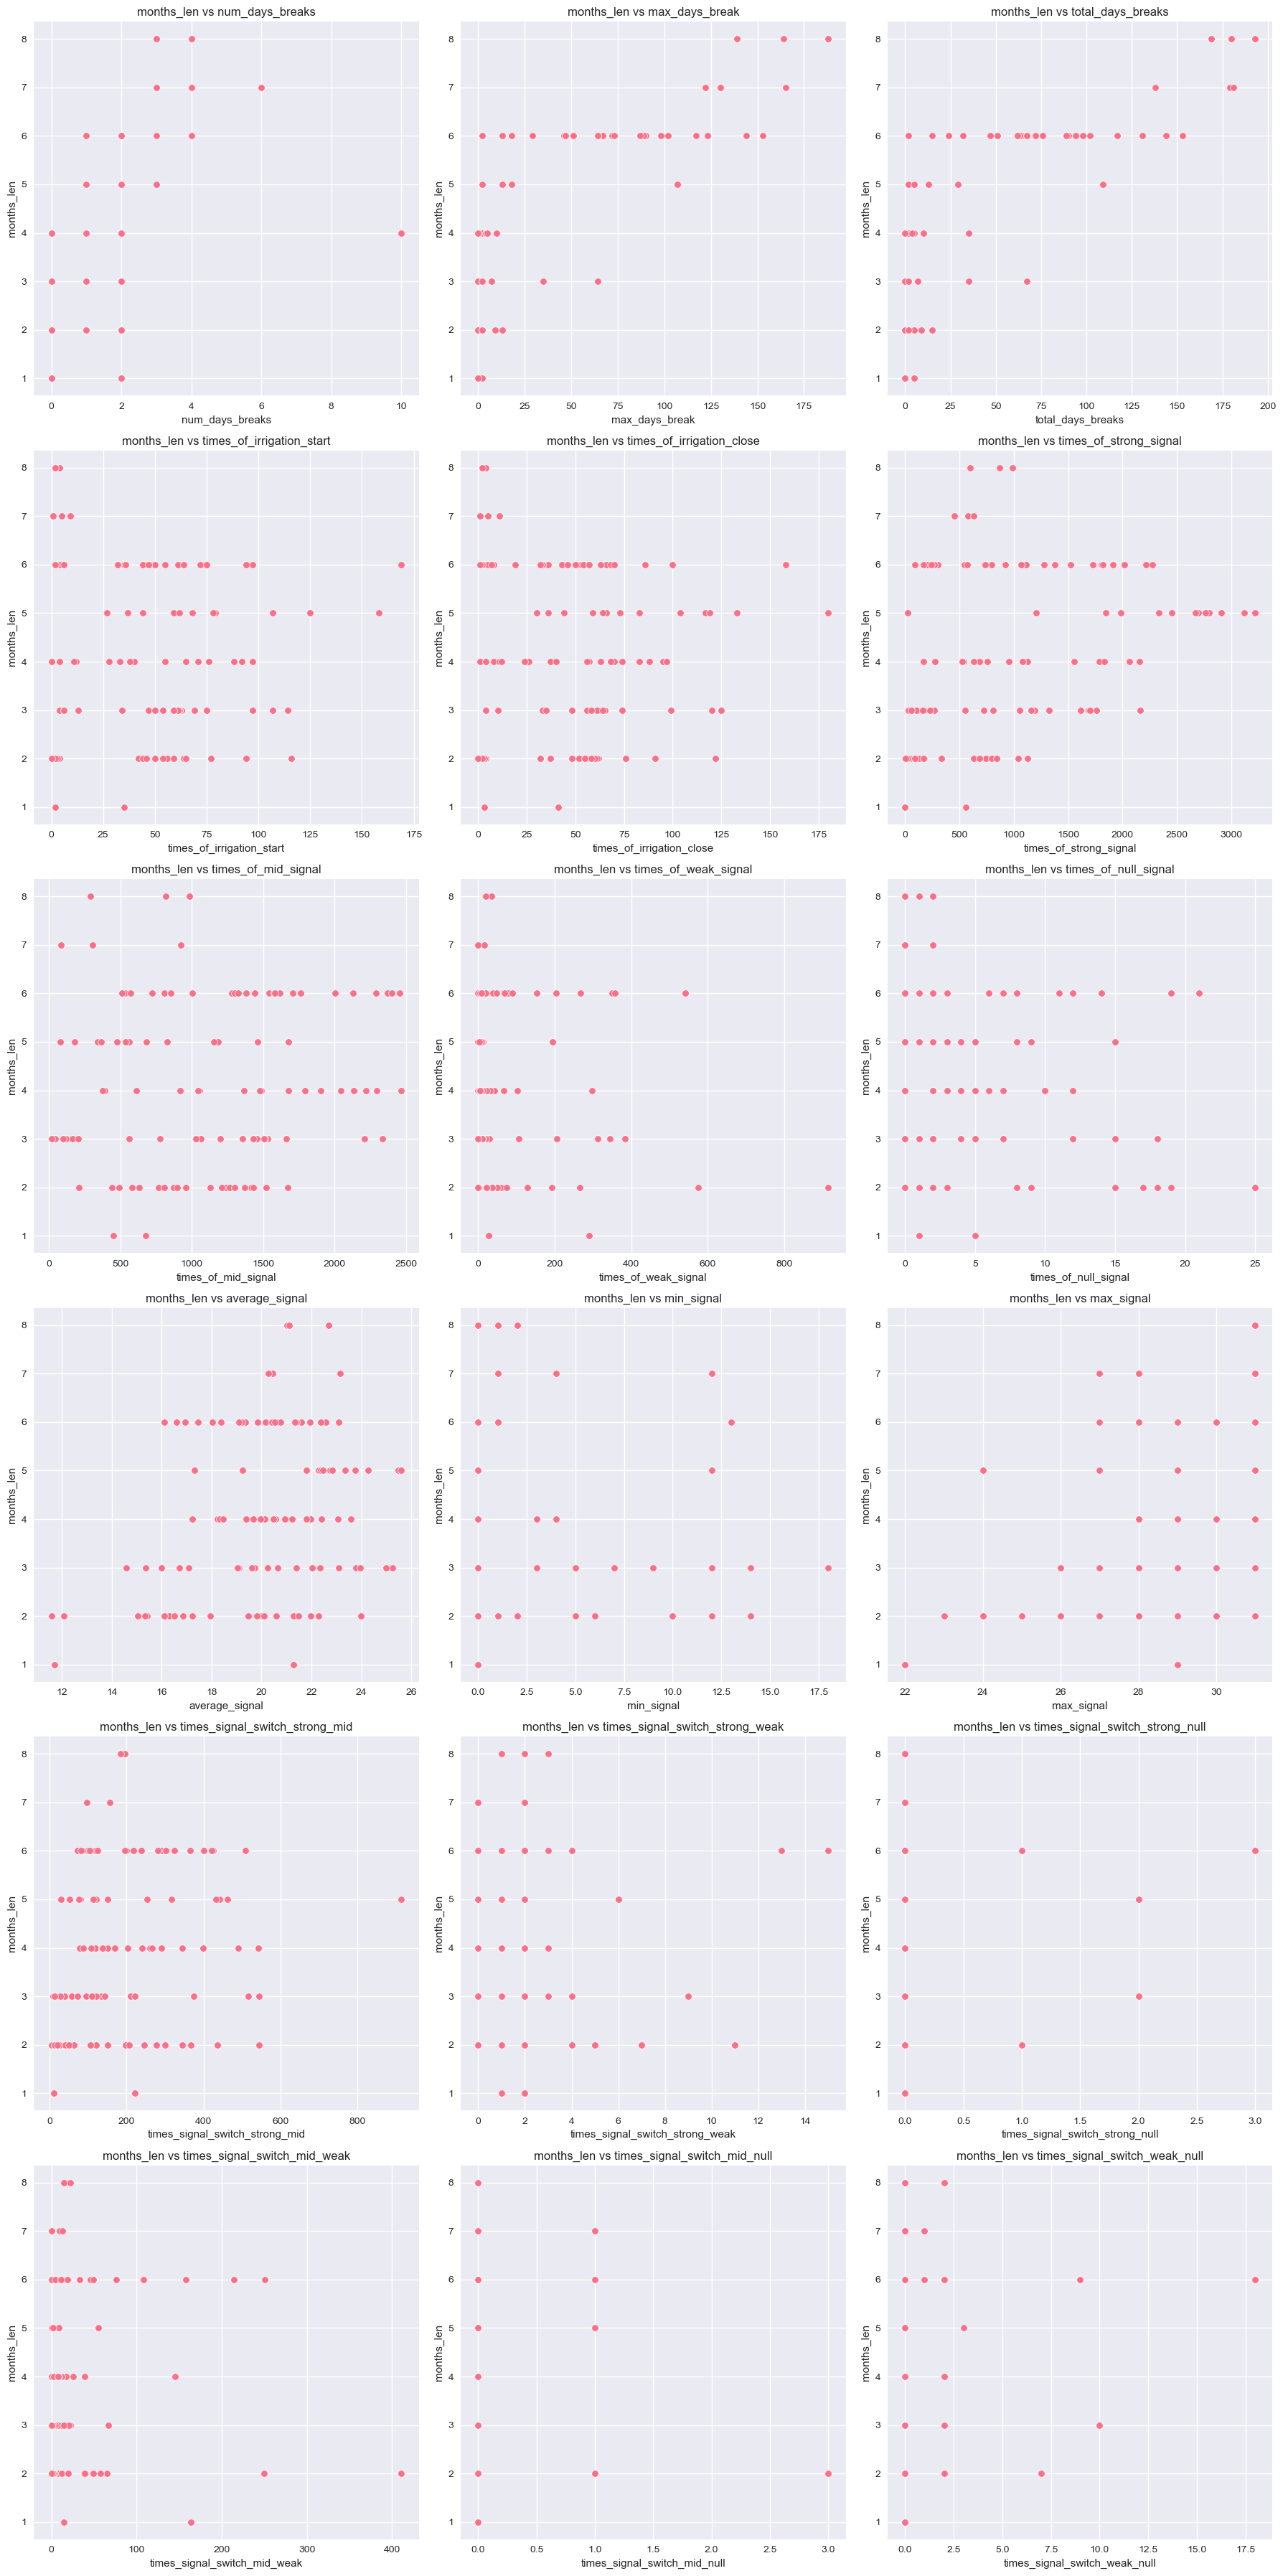

Correlation with months_len:
months_len                         1.000000
total_days_breaks                  0.709014
max_days_break                     0.706041
max_signal                         0.366060
num_days_breaks                    0.327698
times_of_strong_signal             0.301391
average_signal                     0.281523
times_signal_switch_strong_mid     0.172532
times_of_mid_signal                0.111589
times_signal_switch_weak_null      0.092260
times_signal_switch_strong_null    0.087034
times_signal_switch_strong_weak    0.049782
times_signal_switch_mid_null      -0.014396
times_signal_switch_mid_weak      -0.048198
times_of_null_signal              -0.052763
times_of_irrigation_start         -0.062742
times_of_irrigation_close         -0.067743
times_of_weak_signal              -0.110495
min_signal                        -0.148153
Name: months_len, dtype: float64


In [ ]:
# # Key variables to compare with months_len
# factors = [
#     'num_days_breaks', 'max_days_break', 'total_days_breaks',
#     'average_signal', 'min_signal', 'max_signal'
# ]

# Key variables to compare with months_len
factors = [
    'num_days_breaks', 'max_days_break', 'total_days_breaks',
    'times_of_irrigation_start', 'times_of_irrigation_close',
    'times_of_strong_signal', 'times_of_mid_signal', 'times_of_weak_signal',
    'times_of_null_signal', 'average_signal', 'min_signal', 'max_signal',
    'times_signal_switch_strong_mid', 'times_signal_switch_strong_weak',
    'times_signal_switch_strong_null', 'times_signal_switch_mid_weak',
    'times_signal_switch_mid_null', 'times_signal_switch_weak_null'
]

# Calculate number of rows and columns for subplot grid
n_cols = 3
n_rows = (len(factors) + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(18, 6*n_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(factors, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df_general_log_stat_haida[col], y=df_general_log_stat_haida['months_len'])
    plt.xlabel(col)
    plt.ylabel('months_len')
    plt.title(f'months_len vs {col}')
plt.tight_layout()
plt.show()

# Correlation matrix for months_len and key factors
corr = df_general_log_stat_haida[['months_len'] + factors].corr()
print("Correlation with months_len:")
print(corr['months_len'].sort_values(ascending=False))

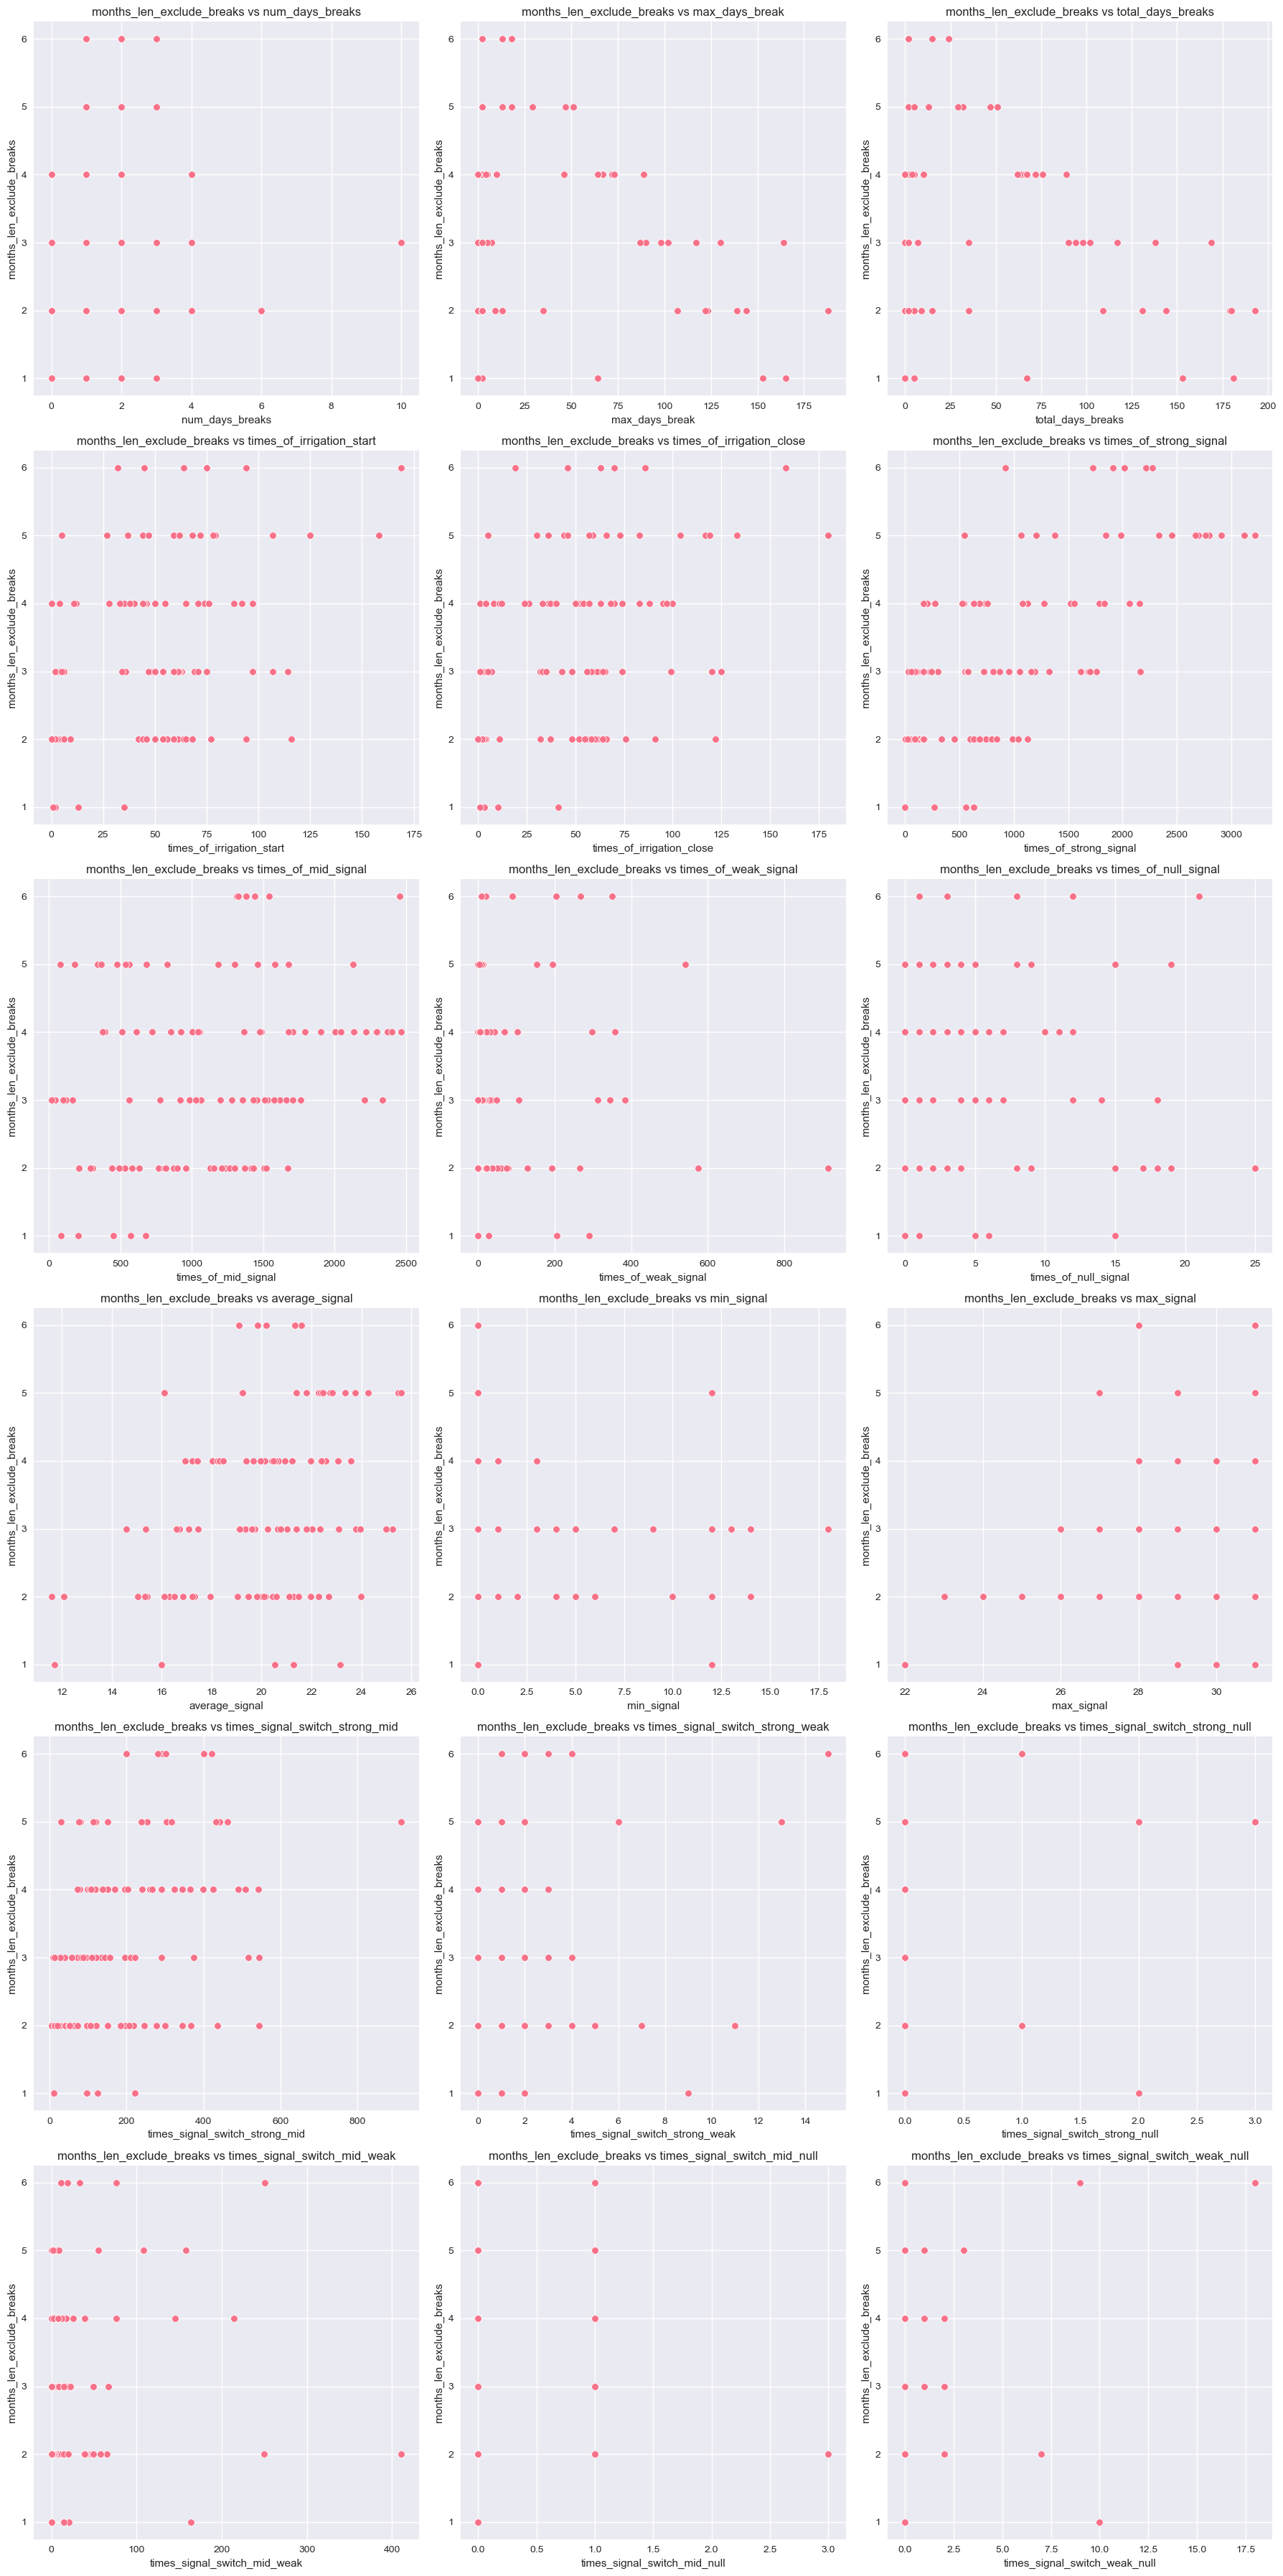

Correlation with months_len_exclude_breaks:
months_len_exclude_breaks          1.000000
times_of_strong_signal             0.661426
max_signal                         0.405371
times_of_irrigation_start          0.381023
times_of_irrigation_close          0.362470
times_signal_switch_strong_mid     0.346238
average_signal                     0.328511
times_of_mid_signal                0.269202
times_signal_switch_strong_null    0.133420
times_signal_switch_weak_null      0.132852
times_signal_switch_strong_weak    0.127607
times_of_null_signal               0.083501
times_signal_switch_mid_weak       0.006312
times_of_weak_signal              -0.010963
times_signal_switch_mid_null      -0.011103
num_days_breaks                   -0.123358
min_signal                        -0.208485
max_days_break                    -0.236022
total_days_breaks                 -0.243739
Name: months_len_exclude_breaks, dtype: float64


In [ ]:
# # Key variables to compare with months_len
# factors = [
#     'num_days_breaks', 'max_days_break', 'total_days_breaks',
#     'average_signal', 'min_signal', 'max_signal'
# ]

# Key variables to compare with months_len
factors = [
    'num_days_breaks', 'max_days_break', 'total_days_breaks',
    'times_of_irrigation_start', 'times_of_irrigation_close',
    'times_of_strong_signal', 'times_of_mid_signal', 'times_of_weak_signal',
    'times_of_null_signal', 'average_signal', 'min_signal', 'max_signal',
    'times_signal_switch_strong_mid', 'times_signal_switch_strong_weak',
    'times_signal_switch_strong_null', 'times_signal_switch_mid_weak',
    'times_signal_switch_mid_null', 'times_signal_switch_weak_null'
]

# Calculate number of rows and columns for subplot grid
n_cols = 3
n_rows = (len(factors) + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(18, 6*n_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(factors, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df_general_log_stat_haida[col], y=df_general_log_stat_haida['months_len_exclude_breaks'])
    plt.xlabel(col)
    plt.ylabel('months_len_exclude_breaks')
    plt.title(f'months_len_exclude_breaks vs {col}')
plt.tight_layout()
plt.show()

# Correlation matrix for months_len_exclude_breaks and key factors
corr = df_general_log_stat_haida[['months_len_exclude_breaks'] + factors].corr()
print("Correlation with months_len_exclude_breaks:")
print(corr['months_len_exclude_breaks'].sort_values(ascending=False))

Feature importances for predicting months_len_exclude_breaks:
times_of_strong_signal             0.447280
times_of_mid_signal                0.273782
times_signal_switch_strong_mid     0.096204
times_signal_switch_strong_weak    0.021138
times_of_irrigation_start          0.021007
times_signal_switch_mid_weak       0.019686
times_of_null_signal               0.017384
times_of_irrigation_close          0.016950
max_signal                         0.016926
times_of_weak_signal               0.015914
average_signal                     0.015852
max_days_break                     0.012432
total_days_breaks                  0.010657
num_days_breaks                    0.007637
min_signal                         0.003094
times_signal_switch_weak_null      0.001825
times_signal_switch_strong_null    0.001534
times_signal_switch_mid_null       0.000698
dtype: float64


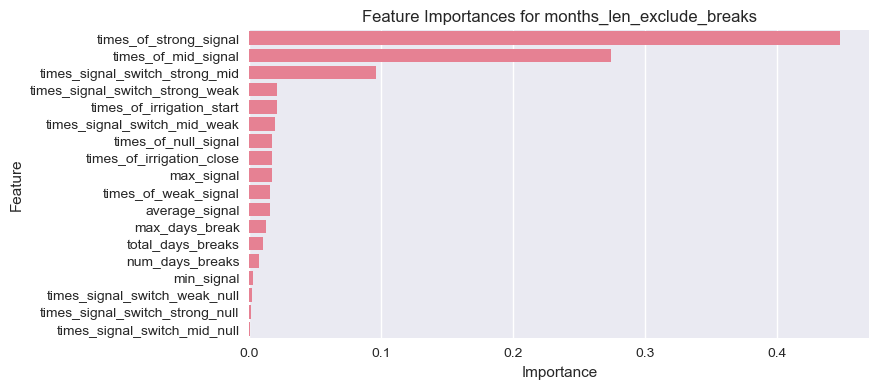

In [ ]:
# Prepare data
features = [
    'num_days_breaks', 'max_days_break', 'total_days_breaks',
    'times_of_irrigation_start', 'times_of_irrigation_close',
    'times_of_strong_signal', 'times_of_mid_signal', 'times_of_weak_signal',
    'times_of_null_signal', 'average_signal', 'min_signal', 'max_signal',
    'times_signal_switch_strong_mid', 'times_signal_switch_strong_weak',
    'times_signal_switch_strong_null', 'times_signal_switch_mid_weak',
    'times_signal_switch_mid_null', 'times_signal_switch_weak_null'
]
X = df_general_log_stat_haida[features]
y = df_general_log_stat_haida['months_len_exclude_breaks']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature importances for predicting months_len_exclude_breaks:")
print(importances)

plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances for months_len_exclude_breaks')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()